In [5]:
from fastai.basics import *
from fastai.vision.all import *

from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
from collections import defaultdict


ROOT = Path("..").resolve()
seed = 256

In [185]:
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap

fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Regular.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Bold.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-ExtraBold.otf")

plt.rcParams['font.family'] = 'Nunito'
plt.rcParams['font.weight'] = "bold"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#003f5c","#7a5195","#ef5675","#ffa600"])

# Top-k resnet18

In [8]:
K = 4


def RMSE(p, y): return torch.sqrt(MSELossFlat()(p, y))
    
class ResNetTopK(nn.Module):
    """Resnet18-like model with a single projection head at end, and a top-k 
    sparsity constraint in penultimate layer to encourage interpretability.
    """
    def __init__(self, k=32, n_out=1000, pretrained=True, **kwargs):
        super(ResNetTopK, self).__init__()
        if pretrained:
            self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT, **kwargs)
        else:
            self.resnet = resnet18(weights=None, **kwargs)
        self.k = k
        # change n_out features
        n_fc_in = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(n_fc_in, n_out)

    def forward(self, x):
        # Get features from all layers except the final FC
        features = nn.Sequential(*list(self.resnet.children())[:-1])(x)
        features = torch.flatten(features, 1)
        
        # Apply ReLU activation
        features = nn.functional.relu(features)
        
        # top-k constraint
        topk_values, topk_indices = torch.topk(features, k=self.k, dim=1)
        sparse_features = torch.zeros_like(features)
        sparse_features.scatter_(1, topk_indices, topk_values)

        # print(f"Non-zero activations per sample: {(sparse_features != 0).sum(1)}")
        
        # final fully connected layer
        x = self.resnet.fc(sparse_features)
        return x

In [11]:

df = pd.read_csv(ROOT / 'data/galaxies.csv', dtype={'objID': str})
df = df[(df.oh_p50 > 0) & (df.lgm_tot_p50 > 0) & (df.sfr_tot_p50 > -10)].copy()

# df = df.sample(10000, random_state=256).copy()

n_galaxies = len(df)

# set a random state
rng = np.random.RandomState(seed)

In [187]:
df.columns

Index(['objID', 'DR7ObjID', 'specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp',
       'velDispErr', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroMag_r', 'petroR50_r', 'petroR90_r', 'bptclass',
       'oh_p50', 'lgm_tot_p50', 'sfr_tot_p50', 'nii_6584_flux',
       'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err',
       'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux',
       'h_beta_flux_err', 'reliable'],
      dtype='object')

In [12]:
# fastai "data blocks" determine how data can be fed into a model
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('objID', pref=f'{ROOT}/data/images-sdss/', suff='.jpg'),
    get_y=ColReader('oh_p50'),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=[Resize(160), CropPad(144)],
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.0, max_warp=0, p_lighting=0) + [Normalize()]
)

# "data loaders" actually load the data 
dls = ImageDataLoaders.from_dblock(dblock, df, bs=64)

In [6]:
cnn_model = ResNetTopK(k=K, n_out=1, pretrained=True).to("mps")

In [7]:
learn = Learner(
    dls,
    cnn_model,
    loss_func=RMSE,
    opt_func=ranger,
)

In [7]:
learn.fit_one_cycle(20, 0.1)

epoch,train_loss,valid_loss,time
0,0.318600,0.266086,11:56
1,0.186636,0.256424,12:13
2,0.218749,0.392514,18:30
3,0.181272,0.220448,12:16
4,0.181404,0.128711,12:12
5,0.180500,0.209401,12:22
6,0.170569,0.400013,12:14
7,0.124144,0.294467,12:20
8,0.112030,0.146191,12:25
9,0.101036,0.141136,12:19


In [10]:
model_path = f"{ROOT}/model/resnet18-topk_{K}-metallicity.pth"
# torch.save(learn.model, model_path)

cnn_model = torch.load(model_path)

/var/folders/hz/8kslz26x4w72kd6r6lm3zc480000gn/T/ipykernel_17583/928007578.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model = torch.load(model_path)


# View activated features

In [9]:
def get_all_sparse_activations(loader, model):
    activations = []
    with torch.no_grad():
        layers = nn.Sequential(*list(model.resnet.children())[:-1], nn.Flatten())
        
        for xb, _ in tqdm(loader):    
            activations.append(layers(xb))
    return torch.concat(activations, 0).cpu().numpy()

In [10]:
activs = get_all_sparse_activations(dls.valid, cnn_model)
activs.shape

100%|█████████████████████████████████████████████████████████████████████| 367/367 [01:04<00:00,  5.66it/s]


(23444, 512)

In [14]:
activs_path = f"{ROOT}/results/resnet18-topk_{K}-metallicity/activations.npy"
# np.save(activs_path, activs)

activations = np.load(activs_path)

In [15]:
(activations.max(0) > 0).sum()

11

In [16]:

# make a dictionary for every non-zero activated feature, where the
# key is the latent activation index, and the value is a list of tuples
# of (image index, activation strength)
feature_dict = defaultdict(list)

# Process each image's activations
for img_idx, img_activations in enumerate(activations):
    # Find non-zero activations
    non_zero = np.nonzero(img_activations)[0]

    # Add to dictionary
    for feature_idx in non_zero:
        activation_strength = img_activations[feature_idx]
        feature_dict[int(feature_idx)].append((int(img_idx), float(activation_strength)))

# Sort each list by activation strength in descending order
for feature_idx in feature_dict:
    feature_dict[feature_idx].sort(key=lambda x: x[1], reverse=True)


In [17]:
print([(k, len(feature_dict[k])) for k in feature_dict])

[(61, 23348), (256, 20605), (49, 9414), (461, 2784), (223, 48), (87, 40), (84, 1), (44, 10), (247, 1), (94, 2), (428, 1)]


In [18]:
valid_idx_to_objid = lambda idx: dls.valid.items.iloc[idx].objID

def plot_max_activating_galaxies(feature_dict, activation_index, top_n=5):
    galaxy_indices_and_activations = feature_dict[activation_index]

    top_n = min(top_n, len(galaxy_indices_and_activations))

    fig, axes = plt.subplots(1, top_n, figsize=(top_n * 1.5, 2), dpi=100, squeeze=0)
    axes = axes.reshape(-1)
    for ax, [galaxy_index, feature_activation] in zip(axes, galaxy_indices_and_activations):
        image = Image.open(f"{ROOT}/data/images-sdss/{valid_idx_to_objid(galaxy_index)}.jpg")
        ax.imshow(image, origin='lower')
        ax.set_title(f"{feature_activation:.4f}", fontsize=10)
        ax.axis("off")
    fig.suptitle(f"Activation {activation_index} ({len(galaxy_indices_and_activations)} galaxies)", fontsize=12)
    fig.subplots_adjust(left=0, right=1, top=0.8, wspace=0.02)

In [18]:
for k in tqdm(feature_dict):
    plot_max_activating_galaxies(feature_dict, k, top_n=10)
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-metallicity/figures/activation-{k}.png")
    plt.close()

100%|███████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.75it/s]


# Plot normalized activation vs metallicity

Only use common activations (i.e. ones that have non-zero values for 100+ cases)

Activation  61 (N=23348): Pearson rho = 0.8513
Activation 256 (N=20605): Pearson rho = -0.7182
Activation  49 (N= 9414): Pearson rho = 0.5085
Activation 461 (N= 2784): Pearson rho = 0.2808


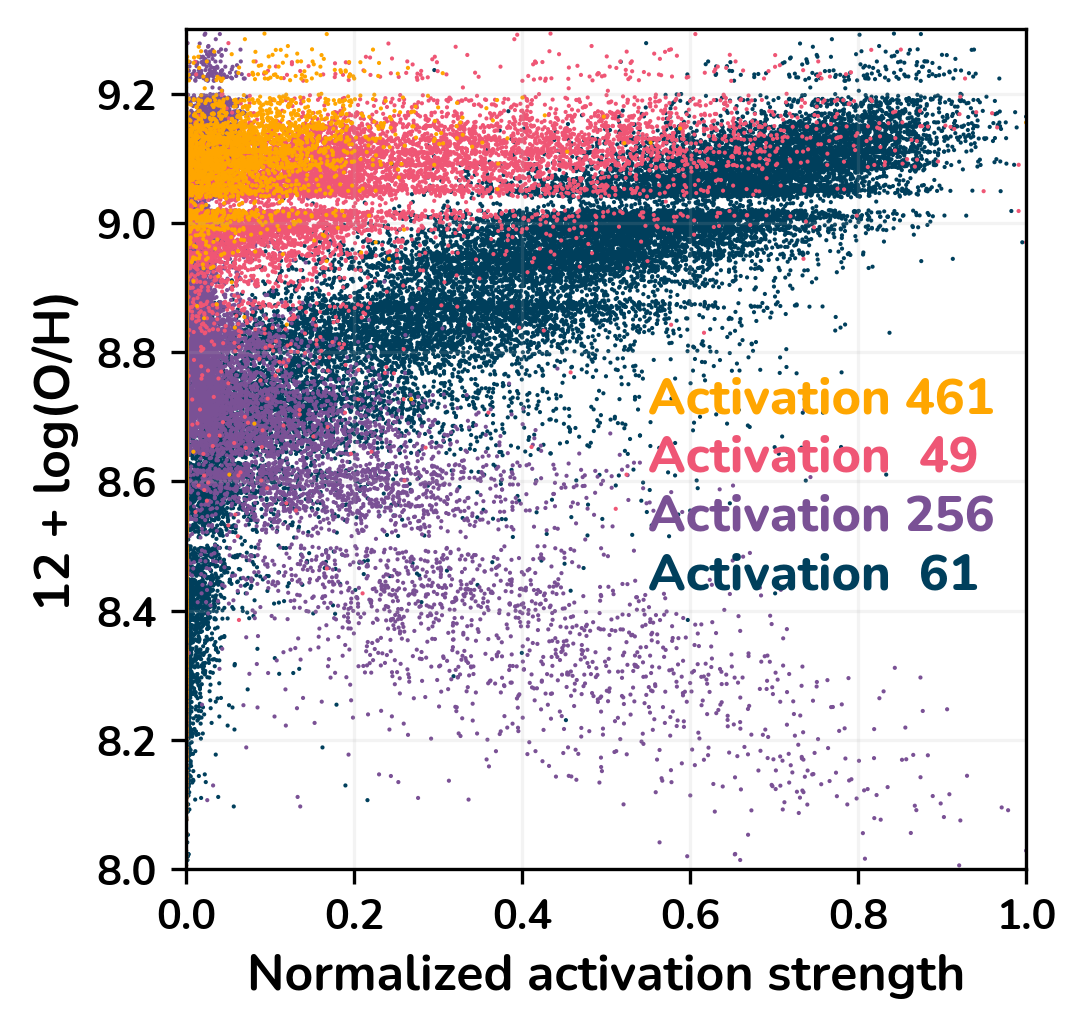

In [186]:
plt.figure(figsize=(3.5, 3.5), dpi=300)
plt.rcParams['font.weight'] = 700

i = 0

for k in feature_dict:
    # most common features
    if len(feature_dict[k]) > 100:
        Pearson_rho = np.corrcoef(activations[:, k] / activations[:, k].max(), dls.valid.items.oh_p50)[0,1]
        
        plt.scatter(
            activations[:, k] / activations[:, k].max(),
            dls.valid.items.oh_p50, 
            edgecolors="none",
            s=1,
            # label=f"#{k} ({len(feature_dict[k])})",
        )

        plt.text(0.55, 0.35 + i*0.07, f"Activation {k:>3}", ha="left", va="center", fontsize=12, transform=plt.gca().transAxes, color=f"C{i}", fontfamily='Nunito', fontweight='extra bold')

        print(f"Activation {k:>3} (N={len(feature_dict[k]):>5}): Pearson rho = {Pearson_rho:.4f}")
        i += 1
plt.xlabel("Normalized activation strength", fontsize=12, fontweight="bold")
plt.ylabel("12 + log(O/H)", fontsize=12, fontweight="bold")
# plt.legend(markerscale=10, loc="center right", framealpha=0, markerfirst=False, borderpad=0.05, handletextpad=0.05, title_fontsize=14)
plt.grid(alpha=0.15)
plt.xlim(0, 1)
plt.ylim(8, 9.3)
plt.show()

In [168]:
def get_weights(activation_index):
    return cnn_model.resnet.fc.weight[:, activation_index].cpu().item()

In [173]:
for k in feature_dict:
    Pearson_rho = np.corrcoef(activations[:, k] / activations[:, k].max(), dls.valid.items.oh_p50)[0,1]
    weight = get_weights(k)
    print(f"Activation {k:>3} (N={len(feature_dict[k]):>5}): Pearson rho = {Pearson_rho:+.4f}, Weight = {weight:+>6.3f}")

Activation  61 (N=23348): Pearson rho = +0.8513, Weight = +0.503
Activation 256 (N=20605): Pearson rho = -0.7182, Weight = -0.593
Activation  49 (N= 9414): Pearson rho = +0.5085, Weight = -0.103
Activation 461 (N= 2784): Pearson rho = +0.2808, Weight = -0.176
Activation 223 (N=   48): Pearson rho = -0.0580, Weight = +0.191
Activation  87 (N=   40): Pearson rho = +0.0334, Weight = -0.026
Activation  84 (N=    1): Pearson rho = -0.0108, Weight = -0.070
Activation  44 (N=   10): Pearson rho = -0.0007, Weight = -0.010
Activation 247 (N=    1): Pearson rho = +0.0038, Weight = -0.034
Activation  94 (N=    2): Pearson rho = +0.0092, Weight = +0.101
Activation 428 (N=    1): Pearson rho = +0.0078, Weight = +0.184
